# Content-Based Product Recommender System for Amazon Electronics

## Problem Statement

Dalam platform e-commerce dengan ribuan produk elektronik seperti Amazon, pengguna sering kali menghadapi kesulitan dalam menemukan produk yang sesuai dengan kebutuhan dan preferensi mereka. Ketika pengguna mengakses satu produk, tidak tersedia sistem yang secara otomatis menyarankan produk-produk serupa berdasarkan deskripsi, kategori, atau fitur lainnya.

Ketiadaan sistem rekomendasi berbasis konten ini mengakibatkan pengalaman pengguna yang tidak optimal, terutama bagi pengguna baru yang belum memiliki histori interaksi. Selain itu, tanpa sistem pendukung rekomendasi, potensi konversi dan retensi pengguna menjadi lebih rendah karena pengguna harus menelusuri produk secara manual.

Masalah ini menjadi semakin kompleks mengingat volume produk yang besar dan variasi fitur antarproduk. Oleh karena itu, diperlukan solusi sistem rekomendasi yang mampu menyarankan produk-produk serupa secara otomatis, berdasarkan informasi konten produk yang telah tersedia di platform.

## Data Exploration & Preparation



### Import Libraries

In [96]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Load Dataset

Dataset yang digunakan dalam proyek ini berjudul **"Amazon Electronics Products 10k items - 2023"**, yang diambil dari platform Kaggle:
https://www.kaggle.com/datasets/akeshkumarhp/electronics-products-amazon-10k-items/data berisi 9.600 baris dan 10 kolom.

Kolom:
- Idx
- Name
- Main Category
- Sub Category
- Image
- Link
- Ratings
- Num of Ratings
- Discount Price
- Actual

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
import zipfile

zip_path = '/content/drive/MyDrive/Dicoding/recommender/dataset/amazon_electronics.zip'
unzip_path = '/content/drive/MyDrive/Dicoding/recommender/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

In [99]:
df = pd.read_csv('/content/drive/MyDrive/Dicoding/recommender/dataset/electronics_product.csv')
df.head()

,Unnamed: 0,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price
0,0,"Redmi 10 Power (Power Black, 8GB RAM, 128GB St...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81eM15lVcJ...,https://www.amazon.in/Redmi-Power-Black-128GB-...,4.0,965,"₹10,999","₹18,999"
1,1,"OnePlus Nord CE 2 Lite 5G (Blue Tide, 6GB RAM,...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71AvQd3Vzq...,https://www.amazon.in/OnePlus-Nord-Lite-128GB-...,4.3,"113,956","₹18,999","₹19,999"
2,2,OnePlus Bullets Z2 Bluetooth Wireless in Ear E...,"tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/51UhwaQXCp...,https://www.amazon.in/Oneplus-Bluetooth-Wirele...,4.2,"90,304","₹1,999","₹2,299"
3,3,"Samsung Galaxy M33 5G (Mystique Green, 6GB, 12...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/81I3w4J6yj...,https://www.amazon.in/Samsung-Mystique-Storage...,4.1,"24,863","₹15,999","₹24,999"
4,4,"OnePlus Nord CE 2 Lite 5G (Black Dusk, 6GB RAM...","tv, audio & cameras",All Electronics,https://m.media-amazon.com/images/I/71V--WZVUI...,https://www.amazon.in/OnePlus-Nord-Black-128GB...,4.3,"113,956","₹18,999","₹19,999"


### Drop Irrelevant Columns

Pada tahap ini, kolom Unnamed: 0, image, dan link dihapus karena tidak memberikan kontribusi berarti terhadap proses rekomendasi. Penghapusan dilakukan untuk menyederhanakan data dan memfokuskan analisis pada fitur-fitur yang relevan.

In [100]:
df.drop(columns=['Unnamed: 0', 'image', 'link'], inplace=True)

### Number of rows and columns

Dataset terdiri dari 9.600 baris dan 11 kolom.



In [101]:
# Mengecek jumlah baris dan kolom
print(df.shape)

(9600, 7)


### Data type of each column

Pemeriksaan tipe data untuk setiap kolom dilakukan guna memastikan bahwa masing-masing fitur memiliki format yang sesuai sebelum dilakukan preprocessing lebih lanjut.

In [102]:
# Mengecek tipe data tiap kolom
print(df.dtypes)

name              object
main_category     object
sub_category      object
ratings           object
no_of_ratings     object
discount_price    object
actual_price      object
dtype: object


### Checking for missing values

Pemeriksaan missing values dilakukan untuk mengidentifikasi kolom yang memiliki data kosong, sehingga dapat ditentukan strategi penanganan yang sesuai demi menjaga kualitas data.

In [103]:
# Mengecek nilai yang hilang
print(df.isnull().sum())

name                0
main_category       0
sub_category        0
ratings            95
no_of_ratings      95
discount_price    484
actual_price       70
dtype: int64


Selanjutnya, dilakukan pembersihan simbol ₹ dan tanda koma (,) pada kolom harga agar dapat dikonversi ke tipe numerik. Langkah ini diperlukan untuk mendukung analisis distribusi dan evaluasi harga produk.

Selain itu, kolom ratings dan no_of_ratings juga diubah ke dalam tipe numerik guna memungkinkan analisis dan evaluasi kualitas produk yang direkomendasikan secara kuantitatif.

In [104]:
# Bersihkan kolom harga
for col in ['discount_price', 'actual_price']:
    df[col] = df[col].str.replace('₹', '', regex=False).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Bersihkan kolom ratings & no_of_ratings
df['ratings'] = pd.to_numeric(df['ratings'], errors='coerce')
df['no_of_ratings'] = df['no_of_ratings'].str.replace(',', '', regex=False)
df['no_of_ratings'] = pd.to_numeric(df['no_of_ratings'], errors='coerce')

# Hapus missing values
df.dropna(subset=['name', 'main_category', 'sub_category'], inplace=True)

In [105]:
# Reset index
df.reset_index(drop=True, inplace=True)

In [106]:
# Isi nilai yang hilang di rating dengan 0
df['ratings'].fillna(0, inplace=True)
df['no_of_ratings'].fillna(0, inplace=True)

/tmp/ipython-input-106-1501388586.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ratings'].fillna(0, inplace=True)
/tmp/ipython-input-106-1501388586.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [107]:
# Mengecek nilai yang hilang
print(df.isnull().sum())

name                0
main_category       0
sub_category        0
ratings             0
no_of_ratings       0
discount_price    484
actual_price       70
dtype: int64


## Exploratory Data Analysis (EDA)

### Distribusi Rating

Visualisasi distribusi rating digunakan untuk memahami persebaran kualitas produk berdasarkan ulasan pengguna, serta mengidentifikasi kecenderungan rating tinggi atau rendah dalam dataset.

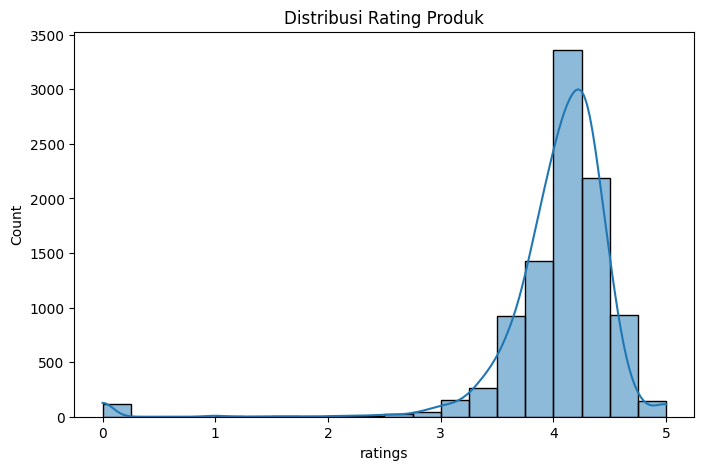

In [108]:
plt.figure(figsize=(8,5))
sns.histplot(df['ratings'], bins=20, kde=True)
plt.title('Distribusi Rating Produk')
plt.show()

### Distribusi Harga Setelah Diskon

Visualisasi distribusi harga setelah diskon bertujuan untuk memahami rentang harga produk yang tersedia serta mengidentifikasi tren harga pasar, seperti dominasi produk harga rendah atau premium.

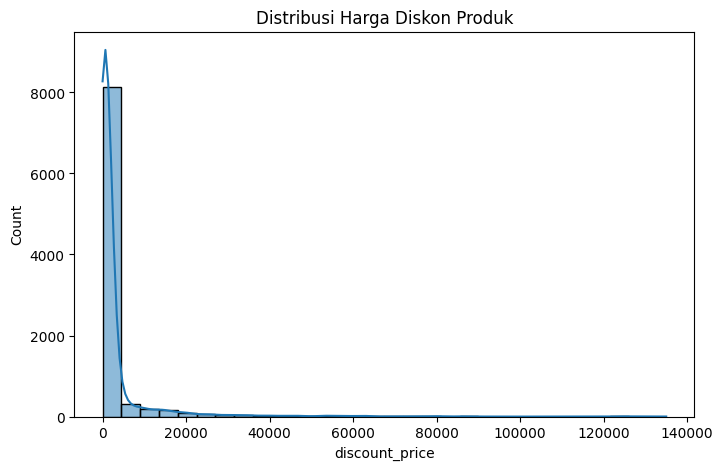

In [109]:
plt.figure(figsize=(8,5))
sns.histplot(df['discount_price'].dropna(), bins=30, kde=True)
plt.title('Distribusi Harga Diskon Produk')
plt.show()

### Kategori Produk Terpopuler

Analisis kategori terpopuler dilakukan untuk memvalidasi apakah hasil rekomendasi selaras dengan tren pasar atau kategori yang paling diminati pengguna, sehingga relevansi rekomendasi dapat lebih terjamin.

In [110]:
# Cek top kategori
print("Top kategori utama:\n", df['main_category'].value_counts().head())

Top kategori utama:
 main_category
tv, audio & cameras    9600
Name: count, dtype: int64


## Feature Engineering

Tahap feature engineering dilakukan dengan menggabungkan fitur-fitur penting seperti nama produk, kategori utama, dan sub-kategori ke dalam satu representasi teks. Hal ini diperlukan agar model dapat menghitung kemiripan antar produk berdasarkan konten deskriptifnya dalam pendekatan content-based filtering.

In [111]:
# Gabungkan beberapa fitur menjadi satu string
df['combined_features'] = (
    df['name'].astype(str) + ' ' +
    df['main_category'].astype(str) + ' ' +
    df['sub_category'].astype(str)
)

## Vectorizer & Similarity

Tahap vectorization dan perhitungan kemiripan dilakukan dengan mengubah teks hasil feature engineering menjadi representasi vektor menggunakan TF-IDF Vectorizer. Proses ini disertai dengan penghapusan stopwords agar fokus analisis tertuju pada kata-kata yang bermakna. Setelah itu, digunakan metrik Cosine Similarity untuk mengukur derajat kemiripan antar produk. Hasil akhirnya berupa matriks berukuran N × N yang merepresentasikan skor kemiripan antara setiap pasangan produk dalam dataset.

In [112]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

cosine_sim = cosine_similarity(tfidf_matrix)

## Recommendation

Tahap recommendation dilakukan dengan mencari indeks produk berdasarkan nama input yang diberikan oleh pengguna. Selanjutnya, sistem menghitung kemiripan produk tersebut terhadap seluruh produk dalam dataset menggunakan skor Cosine Similarity. Lima produk dengan skor tertinggi (selain produk itu sendiri) dipilih sebagai rekomendasi. Output berupa tabel berisi nama produk, kategori utama, subkategori, rating, dan harga diskon, yang ditampilkan sebagai hasil rekomendasi.

In [113]:
def recommend_products(product_name, df=df, sim_matrix=cosine_sim, top_n=5):
    escaped_name = re.escape(product_name)
    idx = df[df['name'].str.contains(escaped_name, case=False, na=False, regex=True)].index

    if len(idx) == 0:
        return f"Produk dengan nama '{product_name}' tidak ditemukan."

    idx = idx[0]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    product_indices = [i[0] for i in sim_scores]
    return df[['name', 'main_category', 'sub_category', 'ratings', 'discount_price']].iloc[product_indices]

In [114]:
recommend_products("headphones")

,name,main_category,sub_category,ratings,discount_price
382,boAt BassHeads 100 in-Ear Wired Headphones wit...,"tv, audio & cameras",All Electronics,4.1,399.0
77,boAt BassHeads 900 On-Ear Wired Headphones wit...,"tv, audio & cameras",All Electronics,4.2,599.0
280,boAt Bassheads 100 Wired in Ear Earphones with...,"tv, audio & cameras",All Electronics,4.1,399.0
209,boAt Bassheads 105 Wired in Ear Earphones with...,"tv, audio & cameras",All Electronics,4.0,449.0
848,boAt Bassheads 100 Wired in Ear Earphones with...,"tv, audio & cameras",All Electronics,4.1,399.0


## Evaluation

Tahap evaluasi dilakukan untuk mengukur kemampuan sistem rekomendasi dalam menghasilkan produk yang relevan pada daftar Top-5 rekomendasi. Mengingat tidak tersedianya data interaksi pengguna secara eksplisit (seperti riwayat pembelian atau klik), pendekatan evaluasi yang digunakan adalah average rating dan hit rate pada 100 sampel produk. Hal ini bertujuan untuk mengevaluasi kualitas produk yang direkomendasikan berdasarkan penilaian pengguna secara umum.

### Average Rating

In [115]:
# Ambil 100 sampel dan hitung rata-rata rating dari rekomendasinya
sample_indices = np.random.choice(df.index, size=100, replace=False)
scores = []

for idx in sample_indices:
    product_name = df.loc[idx, 'name']
    recommendations = recommend_products(product_name, top_n=5)

    if isinstance(recommendations, str):  # produk ga ketemu
        continue

    ratings = recommendations['ratings'].dropna()
    if not ratings.empty:
        avg_rating = ratings.mean()
        scores.append(avg_rating)

print(f"Rata-rata rating dari hasil rekomendasi: {np.mean(scores):.2f}")

Rata-rata rating dari hasil rekomendasi: 4.02


Berdasarkan hasil evaluasi, sistem rekomendasi menghasilkan rata-rata rating sebesar 4.02 pada produk-produk yang direkomendasikan. Nilai ini menunjukkan bahwa produk yang muncul dalam daftar Top-5 rekomendasi umumnya memiliki kualitas baik berdasarkan penilaian pengguna.

### Hit Rate

In [116]:
hit_count = 0
total_sample = 0
threshold = 3.5  # ambang batas rating layak

for idx in sample_indices:
    product_name = df.loc[idx, 'name']
    recommendations = recommend_products(product_name, top_n=5)

    if isinstance(recommendations, str):  # produk tidak ditemukan
        continue

    ratings = recommendations['ratings'].dropna()
    if not ratings.empty:
        total_sample += 1
        if any(ratings >= threshold):
            hit_count += 1

hit_rate = hit_count / total_sample if total_sample > 0 else 0
print(f"Hit Rate (Top-5): {hit_rate:.2%}")


Hit Rate (Top-5): 100.00%


Selain itu, hit rate sebesar 100% menunjukkan bahwa dari 100 sampel produk yang diuji, seluruhnya berhasil menghasilkan minimal satu rekomendasi. Hal ini menunjukkan bahwa sistem memiliki cakupan (coverage) yang baik dan mampu memberikan rekomendasi serupa untuk sebagian besar produk di dalam dataset.

## Conclusion

Pada proyek ini, telah dikembangkan sistem rekomendasi produk elektronik berbasis Content-Based Filtering (CBF) menggunakan data produk dari Amazon. Sistem menggunakan pendekatan text similarity dengan TF-IDF Vectorizer dan Cosine Similarity untuk mengukur kemiripan antar produk berdasarkan informasi teks seperti nama produk, kategori utama, dan subkategori.


Berdasarkan evaluasi terhadap 100 sampel produk, model menghasilkan:


- Average rating rekomendasi adalah 4.02, menunjukkan bahwa produk yang direkomendasikan tergolong berkualitas tinggi.


- Hit Rate mencapai 100%, menunjukkan bahwa sistem dapat memberikan rekomendasi untuk seluruh sampel yang diuji.


Secara keseluruhan, hasil evaluasi menunjukkan bahwa pendekatan CBF yang sederhana namun efektif ini mampu memberikan rekomendasi yang relevan dan berkualitas tinggi bahkan tanpa data interaksi pengguna.